In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
plt.style.use('fivethirtyeight')


from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array


def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.shape

(48895, 16)

In [3]:
df.fillna(0, inplace=True)

In [4]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


# Buang Outlier dan Feature Selection

In [5]:
Temp_dict2 = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}
df['room_type'] = df['room_type'].map(Temp_dict2)

Temp_dict = {'Bronx': 1, 'Staten Island': 2, 'Queens': 3, 'Brooklyn': 4, 'Manhattan': 5}
df['neighbourhood_group'] = df['neighbourhood_group'].map(Temp_dict)

temp_dict = {}
for i, v in enumerate(df.groupby('neighbourhood').mean()['price'].sort_values(ascending=True).items()):
    temp_dict[v[0]] = i+1
df['neighbourhood'] = df['neighbourhood'].map(temp_dict)
df = df[df['price'] < 335]
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4,93,40.64749,-73.97237,2,149,1,9,0.21,6,365
1,5,210,40.75362,-73.98377,3,225,1,45,0.38,2,355
2,5,137,40.80902,-73.94190,2,150,3,0,0.00,1,365
3,4,185,40.68514,-73.95976,3,89,1,270,4.64,1,194
4,5,149,40.79851,-73.94399,3,80,10,9,0.10,1,0


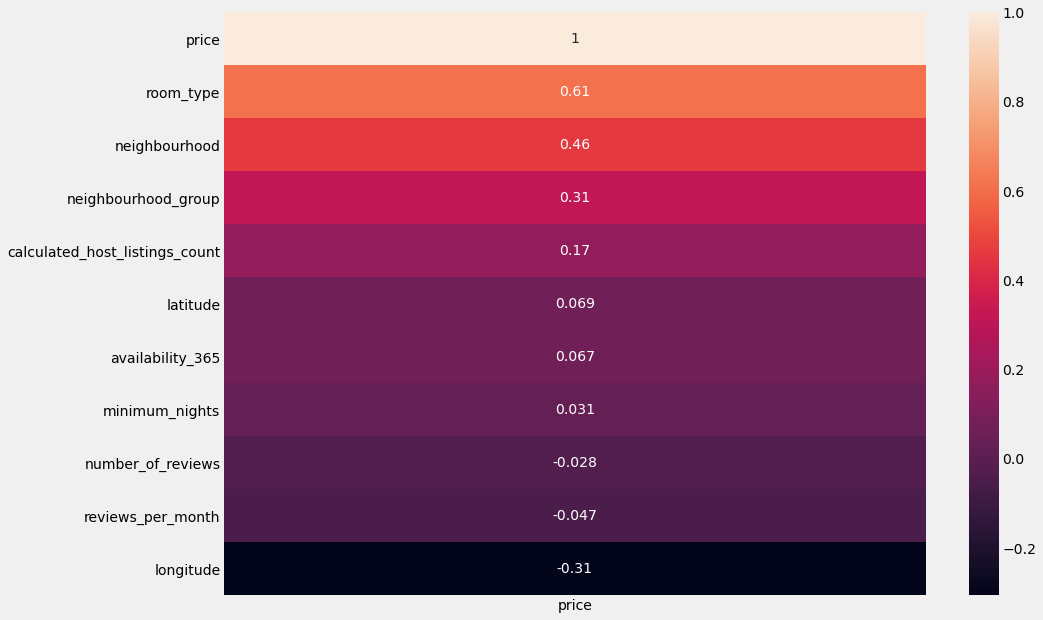

In [6]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr()[['price']].sort_values('price', ascending=False), annot=True);

In [7]:
df1 = df.copy()
# neighbourhood, room_type, neighbourhood_group, longitude, calculated_host_listings_count
df1 = df1[['neighbourhood', 'room_type', 'price']]
df1.head()

,neighbourhood,room_type,price
0,93,2,149
1,210,3,225
2,137,2,150
3,185,3,89
4,149,3,80


In [8]:
# Splitting Dataset
x1 = df1.drop(columns='price')
y1 = df1['price']

# train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

In [9]:
linear1 = LinearRegression()
linear1.fit(x1_train, y1_train)
y_test_pred_fs_lr = linear1.predict(x1_test)
y_train_pred_fs_lr = linear1.predict(x1_train)

poly_reg_lr = make_pipeline(
        PF(2, include_bias=False),
        LinearRegression()
    )
poly_reg_lr.fit(x1_train, y1_train)
# predict
y_test_pred_fs_lr_poly = poly_reg_lr.predict(x1_test)
y_train_pred_fs_lr_poly = poly_reg_lr.predict(x1_train)

In [10]:
import joblib

In [11]:
ridge = Ridge()
ridge.fit(x1_train, y1_train)
y_test_pred_fs_ridge = ridge.predict(x1_test)
y_train_pred_fs_ridge = ridge.predict(x1_train)

poly_reg_ridge = make_pipeline(
        PF(2, include_bias=False),
        Ridge()
    )
poly_reg_ridge.fit(x1_train, y1_train)
joblib.dump(poly_reg_ridge, 'model_final_project_fix')
# predict
y_test_pred_fs_ridge_poly = poly_reg_ridge.predict(x1_test)
y_train_pred_fs_ridge_poly = poly_reg_ridge.predict(x1_train)

In [12]:
lasso = Lasso()
lasso.fit(x1_train, y1_train)
y_test_pred_fs_lasso = lasso.predict(x1_test)
y_train_pred_fs_lasso = lasso.predict(x1_train)

poly_reg_lasso = make_pipeline(
        PF(2, include_bias=False),
        Lasso()
    )
poly_reg_lasso.fit(x1_train, y1_train)
# predict
y_test_pred_fs_lasso_poly = poly_reg_lasso.predict(x1_test)
y_train_pred_fs_lasso_poly = poly_reg_lasso.predict(x1_train)

In [13]:
elasticnet = ElasticNet()
elasticnet.fit(x1_train, y1_train)
y_test_pred_fs_en = elasticnet.predict(x1_test)
y_train_pred_fs_en = elasticnet.predict(x1_train)

poly_reg_en = make_pipeline(
        PF(2, include_bias=False),
        ElasticNet()
    )
poly_reg_en.fit(x1_train, y1_train)
# predict
y_test_pred_fs_en_poly = poly_reg_en.predict(x1_test)
y_train_pred_fs_en_poly = poly_reg_en.predict(x1_train)

In [14]:
rfr = RandomForestRegressor()
rfr.fit(x1_train, y1_train)
y_test_pred_rfr = rfr.predict(x1_test)
y_train_pred_rfr = rfr.predict(x1_train)

In [15]:
pd.concat([pd.DataFrame({'Dataset': ['LinearRegression_labelencoder_fs'], 
              'CV error': [ (cross_val_score(linear1, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(linear1, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_lr))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_lr))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_lr)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_lr)]
             }),
           
           pd.DataFrame({'Dataset': ['LinearRegression_labelencoder_poly_fs'], 
              'CV error': [ (cross_val_score(poly_reg_lr, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(poly_reg_lr, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_lr_poly))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_lr_poly))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_lr_poly)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_lr_poly)]
             }),
           
           pd.DataFrame({'Dataset': ['Ridge_labelencoder_fs'], 
              'CV error': [ (cross_val_score(ridge, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(ridge, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_ridge))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_ridge))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_ridge)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_ridge)]
             }),
           
           pd.DataFrame({'Dataset': ['Ridge_labelencoder_poly_fs'], 
              'CV error': [ (cross_val_score(poly_reg_ridge, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(poly_reg_ridge, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_ridge_poly))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_ridge_poly))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_ridge_poly)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_ridge_poly)]
             }),
           
           pd.DataFrame({'Dataset': ['Lasso_labelencoder_fs'], 
              'CV error': [ (cross_val_score(lasso, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(lasso, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_lasso))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_lasso))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_lasso)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_lasso)]
             }),
           
           pd.DataFrame({'Dataset': ['Lasso_labelencoder_poly_fs'], 
              'CV error': [ (cross_val_score(poly_reg_lasso, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(poly_reg_lasso, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_lasso_poly))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_lasso_poly))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_lasso_poly)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_lasso_poly)]
             }),
           
           pd.DataFrame({'Dataset': ['ElasticNet_labelencoder_fs'], 
              'CV error': [ (cross_val_score(elasticnet, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(elasticnet, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_en))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_en))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_en)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_en)]
             }),
           
           pd.DataFrame({'Dataset': ['ElasticNet_labelencoder_poly_fs'], 
              'CV error': [ (cross_val_score(poly_reg_en, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(poly_reg_en, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_fs_en_poly))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_fs_en_poly))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_fs_en_poly)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_fs_en_poly)]
             }),
           
           pd.DataFrame({'Dataset': ['RandomForest_labelencoder_fs'], 
              'CV error': [ (cross_val_score(rfr, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y_train_pred_rfr))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y_test_pred_rfr))],
              'Training_R2_Score' : [r2_score(y1_train,y_train_pred_rfr)],
              'Test_R2_Score' : [r2_score(y1_test,y_test_pred_rfr)]
             }),
           
    
    
    
], ignore_index=True)

,Dataset,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
0,LinearRegression_labelencoder_fs,-49.655697,1.810815,49.514975,49.710498,0.471703,0.469516
1,LinearRegression_labelencoder_poly_fs,-48.253387,1.597585,48.109576,48.230159,0.501267,0.500640
2,Ridge_labelencoder_fs,-49.655691,1.810902,49.514976,49.710499,0.471703,0.469516
3,Ridge_labelencoder_poly_fs,-48.253151,1.596617,48.109587,48.230416,0.501267,0.500635
4,Lasso_labelencoder_fs,-49.688412,1.861058,49.550708,49.746339,0.470940,0.468751
5,Lasso_labelencoder_poly_fs,-48.405752,1.587395,48.266795,48.375155,0.498002,0.497633
6,ElasticNet_labelencoder_fs,-54.500259,2.351694,54.408896,54.532360,0.362111,0.361612
7,ElasticNet_labelencoder_poly_fs,-48.573972,1.669176,48.447709,48.460183,0.494232,0.495866
8,RandomForest_labelencoder_fs,-47.936251,1.570744,46.956830,47.616236,0.524881,0.513272


In [30]:
names = df1.columns.tolist()
print("LR regression    =", pretty_print_linear(linear1.coef_, names, sort=True))
print("Ridge regression =", pretty_print_linear(ridge.coef_, names, sort=True))
print("Lasso regression =", pretty_print_linear(lasso.coef_, names, sort=True))
print("EN regression    =", pretty_print_linear(elasticnet.coef_, names, sort=True))

LR regression    = 65.458 * room_type + 0.457 * neighbourhood
Ridge regression = 65.452 * room_type + 0.457 * neighbourhood
Lasso regression = 61.909 * room_type + 0.467 * neighbourhood
EN regression    = 22.913 * room_type + 0.575 * neighbourhood


---